In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Analyse des accidents de la route en France  
## Introduction
Les accidents de la route constituent un enjeu majeur de santé publique en France, avec plusieurs milliers de morts et de blessés graves chaque année. Leur compréhension repose sur l’analyse conjointe de facteurs temporels, environnementaux, infrastructurels et humains.

Ce projet s’appuie sur les données officielles des accidents corporels de la circulation en France, mises à disposition par les autorités publiques. Ces données décrivent, pour chaque accident, ses caractéristiques temporelles, géographiques, environnementales ainsi que certaines informations sur les usagers et les véhicules impliqués.

L’objectif de ce travail est de proposer une analyse statistique exploratoire des accidents de la route, en mettant l’accent sur les facteurs associés à la **gravité des accidents**, tout en tenant compte des limites inhérentes aux données disponibles.


In [8]:
%pip install -r requirements.txt

# modules 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import re
from io import BytesIO
from urllib import request
import requests
from functools import reduce



# Fonctions
from modules import module_BAAC
from modules import module_region
from modules import graph_baac
from modules import graph_region


Note: you may need to restart the kernel to use updated packages.


### Présentation des données

L’analyse repose principalement sur les jeux de données des accidents de la route survenus en France de 2005 à 2024, ces données sont issues d'API publiques (data.gouv.fr, INSEE et transport.data.gouv.fr). Chaque ligne correspond à un accident et décrit notamment :

- la date et l’heure de l’accident, 
- la localisation géographique (coordonnées, département, commune), 
- les conditions environnementales (luminosité, conditions atmosphériques, état de la chaussée),
- le sexe du conducteur, 
- le nombre de véhicules et d’usagers impliqués, 
- la gravité de l’accident

Le jeux de données antérieurs à 2024 seront mobilisés ponctuellement pour étudier les évolutions temporelles à long terme. Chaque jeu de donnée est intitulé 'BAAC_table_année' et le jeu de donnée regroupant tous les accidents depuis 2005 est intitulé 'BAAC_table'. 


### Construction du dataframe principal

In [9]:
# API Bases de données annuelles des accidents corporels de la circulation routière – 2005 à 2024 (gouvernement.fr)
BAAC_url = "https://www.data.gouv.fr/api/1/datasets/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2024/"

# URLs d'export CSV : consommation quotidienne d’alcool (Odissé - Santé Publique France)
URL_CONSO = "https://odisse.santepubliquefrance.fr/explore/dataset/alcool-consommation-quotidienne-region/download/?format=csv"

# URLs d'export CSV : alcoolisation ponctuelle importante (Odissé - Santé Publique France)
URL_API   = "https://odisse.santepubliquefrance.fr/explore/dataset/alcool-alcoolisation-ponctuelle-importante-api-mensuel-et-hebdomadaire-region/download/?format=csv"

# URLs d'export .XLSX : impoosition par région (gouvernement.fr)
url_impot = "https://www.impots.gouv.fr/node/25517"   # page with the file

In [10]:
BAAC_resources = module_BAAC.get_resources(BAAC_url)
pd.set_option("display.max_rows", None)
pd.options.display.max_colwidth = 300
BAAC_resources[["description", "url"]].head()

,description,url
0,Liste des véhicules immatriculés (hors vélos et engins de déplacement personnel) impliqués dans les accidents corporels issus des BAAC (Bulletin d’Analyse des Accidents Corporels de la circulation) relevés par les forces de l’ordre en 2024.\n,https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2024/20251107-100210/2024.csv
1,Liste des véhicules immatriculés (hors vélos et engins de déplacement personnel) impliqués dans les accidents corporels issus des BAAC (Bulletin d’Analyse des Accidents Corporels de la circulation) relevés par les forces de l’ordre en 2023.\n,https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2024/20251021-142813/2023.csv
2,Table des caractéristiques des accidents corporels de la circulation en 2024 en France (France métropolitaine + DOM + COM +NC).\n,https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2024/20251021-115900/caract-2024.csv
3,Table des lieux des accidents corporels de la circulation en 2024 en France (France métropolitaine + DOM + COM +NC).\n,https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2024/20251021-115812/lieux-2024.csv
4,Table des véhicules impliqués dans les accidents corporels de la circulation en 2024 en France (France métropolitaine + DOM + COM +NC).\n,https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2024/20251107-100240/vehicules-2024.csv


In [11]:
selected_BAAC_table = module_BAAC.select_baac_tables(BAAC_resources)
selected_BAAC_table.head()

,description,url,table,year
0,Table des caractéristiques des accidents corporels de la circulation en 2024 en France (France métropolitaine + DOM + COM +NC).\n,https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2024/20251021-115900/caract-2024.csv,caracteristiques,2024
1,Table des lieux des accidents corporels de la circulation en 2024 en France (France métropolitaine + DOM + COM +NC).\n,https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2024/20251021-115812/lieux-2024.csv,lieux,2024
2,Table des véhicules impliqués dans les accidents corporels de la circulation en 2024 en France (France métropolitaine + DOM + COM +NC).\n,https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2024/20251107-100240/vehicules-2024.csv,vehicules,2024
3,Table des usagers impliqués dans les accidents corporels de la circulation en 2024 en France (France métropolitaine + DOM + COM +NC).\n,https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2024/20251021-115506/usagers-2024.csv,usagers,2024
4,Table des usagers impliqués dans les accidents corporels de la circulation en 2023 en France (France métropolitaine + DOM + COM +NC).,https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2023/20241023-153328/usagers-2023.csv,usagers,2023


In [12]:
BAAC_table = module_BAAC.build_baac_dataframe(selected_BAAC_table)
BAAC_table.head()

,Num_Acc,id_vehicule_x,num_veh_x,place,catu,grav,sexe,an_nais,trajet,secu1,...,com,agg,int,atm,col,adr,lat,long,year,id_usager
0,202000000001,154 742 274,B01,1,1,1,1,1983.0,5,1,...,91657,2,3,1,3,HENRI BARBUSSE (AVENUE),48.70535,2.43841,2020,NaN
1,202000000001,154 742 274,B01,1,1,1,1,1983.0,5,1,...,91657,2,3,1,3,HENRI BARBUSSE (AVENUE),48.70535,2.43841,2020,NaN
2,202000000001,154 742 275,A01,1,1,3,1,1982.0,5,2,...,91657,2,3,1,3,HENRI BARBUSSE (AVENUE),48.70535,2.43841,2020,NaN
3,202000000001,154 742 275,A01,1,1,3,1,1982.0,5,2,...,91657,2,3,1,3,HENRI BARBUSSE (AVENUE),48.70535,2.43841,2020,NaN
4,202000000002,154 742 273,A01,1,1,1,1,1997.0,1,8,...,91657,2,9,7,6,MOUSSEAUX(CHEMIN),48.69000,2.41000,2020,NaN


### Choix des variables conservées

La table principale BAAC_table comporte 61 variables, qui ne sont pas toutes pertinentes dans le cadre de cette étude. Nous avons décidé de conserver les variables suivantes : 'grav' (gravité de l'accident), 'year', 'mois', 'jour', 'hrmn' (→ heure), 'lat', 'long', 'dep', 'agg' (agglomération ou non), 'vma' (vitesse limite), 'nbv', 'catr', 'circ', 'lum', 'atm', 'surf' (paramètres physiques), 'sexe', 'an_nais' (année de naissance). Sur certaines tables, 'hrmn' est un string de la forme 'HH:MM' (avant 2019), sur d'autres 'hrmn' est de la fome HHMM, nous avons donc remplacé 'hmrn' par une variable 'hour' en conservant seulement l'heure de l'accident HH de type int. 


In [138]:
df = BAAC_table.copy()

df['hour'] = df['hrmn'].apply(graph_baac.hrmn_to_hour)

variables_conservees = ["Num_Acc", "grav", "year", "mois", "jour", "hour", "lat", "long", "dep", "agg",
 "vma", "nbv", "catr", "circ", "lum", "atm", "surf", "sexe", "an_nais"]

BAAC_table_sort = df[variables_conservees]
BAAC_table_sort.head()

,Num_Acc,grav,year,mois,jour,hour,lat,long,dep,agg,vma,nbv,catr,circ,lum,atm,surf,sexe,an_nais
0,202000000001,1,2020,3,7,16,48.70535,2.43841,91,2,50,2,4,2,1,1,1,1,1983.0
1,202000000001,1,2020,3,7,16,48.70535,2.43841,91,2,50,2,4,2,1,1,1,1,1983.0
2,202000000001,3,2020,3,7,16,48.70535,2.43841,91,2,50,2,4,2,1,1,1,1,1982.0
3,202000000001,3,2020,3,7,16,48.70535,2.43841,91,2,50,2,4,2,1,1,1,1,1982.0
4,202000000002,1,2020,3,7,8,48.69000,2.41000,91,2,50,2,4,2,2,7,1,1,1997.0


On crée ensuite les tables associées à chaque année à partir de la table principale : 

In [14]:
for i in range(2020, 2025):
    globals()[f'BAAC_table_{i}'] = BAAC_table_sort.loc[BAAC_table_sort['year'] == i].reset_index(drop=True)


### Valeurs manquantes
 
La table principale étant issue de la concaténation de vingt sous-tables, il est nécessaire de vérifier la proportion de mesures disponibles pour chaque variable et chaque année, afin d’éviter d’effectuer des analyses sur des valeurs manquantes (NaN).

Un tableau a été élaboré pour représenter, année par année, la proportion de valeurs effectivement renseignées pour chaque variable. Il permet par exemple de constater que que la variable 'vma' n’a été introduite qu’à partir de 2019. 

In [15]:
important_variables = ["grav", "year", "mois", "jour", "hour", "lat", "long", "dep", "agg",
 "vma", "nbv", "catr", "circ", "lum", "atm", "surf", "sexe", "an_nais"]     


years = range(2020, 2025)
df_proportion = pd.DataFrame(index=years, columns=important_variables)

for i in years:
    table = globals()[f'BAAC_table_{i}']
    for var in important_variables:
        df_proportion.loc[i, var] = 1 - table[var].isna().sum() / len(table)

df_proportion = df_proportion.astype(float)

df_proportion

,grav,year,mois,jour,hour,lat,long,dep,agg,vma,nbv,catr,circ,lum,atm,surf,sexe,an_nais
2020,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000
2021,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.976965
2022,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.978504
2023,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.979453
2024,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.979920


Le choix des variables conservées est donc plutôt satisfaisant puisque les valeurs du tableau sont pour la plupart proches de 1. Il est enfin nécessaire de convertir toutes les variables conservées en int, ou en float, comme par exemple les coordonnées qui sont de type str comme on peut le voir ci-dessous.

In [16]:
for i in range(2020,2025) :
    table = globals()[f'BAAC_table_{i}'][['lat', 'long']].dropna()
    print(i,':', table['lat'].iloc[0], table['long'].iloc[0])
    

2020 : 48.70535 2.43841
2021 : 44.038958 4.348022
2022 : 44.55942 4.72572
2023 : 48.866386 2.323471
2024 : 47.56277 6.75832


On utilise pour cela les fonctions normalize_coordinates et to_int

In [17]:
df = BAAC_table_sort.copy()
df = graph_baac.normalize_coordinates(df)
df = graph_baac.to_int(df)

for var in df.columns : 
    print(f'{var} is type {type(df[var].loc[0])}')

Num_Acc is type <class 'numpy.int64'>
grav is type <class 'numpy.int64'>
year is type <class 'numpy.int64'>
mois is type <class 'numpy.int64'>
jour is type <class 'numpy.int64'>
hour is type <class 'numpy.int64'>
lat is type <class 'numpy.float64'>
long is type <class 'numpy.float64'>
dep is type <class 'float'>
agg is type <class 'numpy.int64'>
vma is type <class 'numpy.int64'>
nbv is type <class 'float'>
catr is type <class 'numpy.int64'>
circ is type <class 'numpy.int64'>
lum is type <class 'numpy.int64'>
atm is type <class 'numpy.int64'>
surf is type <class 'numpy.int64'>
sexe is type <class 'numpy.int64'>
an_nais is type <class 'numpy.float64'>


In [18]:
df[['lat', 'long']].head(1)

,lat,long
0,48.70535,2.43841


In [19]:
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + 
                            df['mois'].astype(str) + '-' + 
                            df['jour'].astype(str))

df['weekday'] = df['date'].dt.day_name()

BAAC_table_norm = df.copy()

BAAC_table_norm[['weekday', 'date']].head()

,weekday,date
0,Saturday,2020-03-07
1,Saturday,2020-03-07
2,Saturday,2020-03-07
3,Saturday,2020-03-07
4,Saturday,2020-03-07


Après avoir nettoyé BAAC_table, on fait de même avec les tables associées à chaque année, en créant aussi une variable date et weekday : 

In [20]:
for i in range(2020, 2025):
    globals()[f'BAAC_table_{i}'] = BAAC_table_norm.loc[BAAC_table_norm['year'] == i].reset_index(drop=True)

BAAC_table_2020.head()

,Num_Acc,grav,year,mois,jour,hour,lat,long,dep,agg,...,nbv,catr,circ,lum,atm,surf,sexe,an_nais,date,weekday
0,202000000001,1,2020,3,7,16,48.70535,2.43841,91.0,2,...,2.0,4,2,1,1,1,1,1983.0,2020-03-07,Saturday
1,202000000001,1,2020,3,7,16,48.70535,2.43841,91.0,2,...,2.0,4,2,1,1,1,1,1983.0,2020-03-07,Saturday
2,202000000001,3,2020,3,7,16,48.70535,2.43841,91.0,2,...,2.0,4,2,1,1,1,1,1982.0,2020-03-07,Saturday
3,202000000001,3,2020,3,7,16,48.70535,2.43841,91.0,2,...,2.0,4,2,1,1,1,1,1982.0,2020-03-07,Saturday
4,202000000002,1,2020,3,7,8,48.69000,NaN,91.0,2,...,2.0,4,2,2,7,1,1,1997.0,2020-03-07,Saturday


## Problématique

Si la fréquence et la localisation des accidents de la route sont relativement bien documentées, la compréhension des **facteurs associés à la gravité des accidents** reste un enjeu central pour l’analyse et la prévention du risque routier.

La problématique principale de ce projet est donc la suivante :

> *Dans quelles conditions temporelles, environnementales et infrastructurelles les accidents de la route sont-ils les plus graves ?*

Cette question sera abordée à travers une analyse descriptive, exploratoire et multivariée des données, sans prétendre établir des relations causales strictes.


### Enjeux et choix méthodologiques

Plusieurs enjeux méthodologiques structurent ce travail :

Premièrement, les données sont observationnelles et ne permettent pas d’identifier des relations causales directes. De plus les variables territoriales agrégées (régions, départements) sont peu nombreuses au regard du nombre d’accidents observés, ce qui limite leur exploitation dans des modèles explicatifs.

En conséquence, l’analyse privilégie une approche descriptive pour dresser un état des lieux des accidents, une analyse exploratoire multivariée (ACP) pour comprendre la structure des relations entre variables ainsi que des modèles de régression visant à identifier les variables **associées** à la gravité des accidents.


## Organisation du notebook

Le notebook est structuré comme suit :

I. Analyse descriptive des accidents de la route  
II. Analyse exploratoire multivariée  
III. Analyse des facteurs associés à la gravité des accidents  
IV. Discussion des résultats et limites  
V. Conclusion

Chaque partie combine des visualisations graphiques et des analyses statistiques adaptées aux objectifs poursuivis.


## I. Analyse descriptive des accidents de la route


A remplir

On commence par une analyse pûrement descriptive. On va plot quelques graphes significatifs, dégager des dynamiques temporelles en soulignant qu'elles sont faibles, ce qui justifiera le choix de ne sélectionner qu'une seule partie dans le II. 

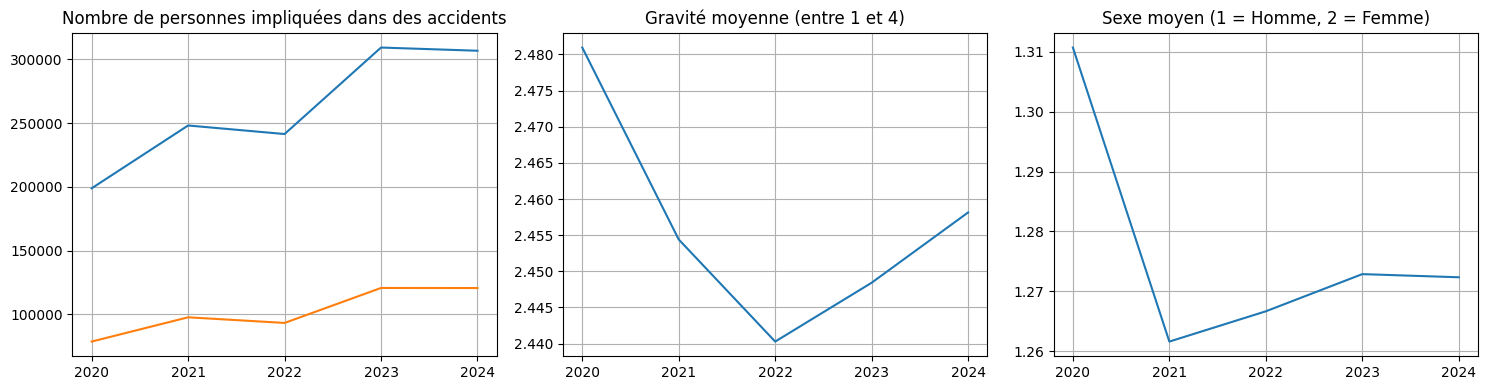

In [21]:
liste_df = [globals()[f'BAAC_table_{i}'] for i in range(2020, 2025)]
annees = range(2020, 2025)
occurences, occurences_graves, grav_moy, sexe_moy = graph_baac.dynamiques_temporelles(liste_df)

fig, axs = plt.subplots(1, 3, figsize=(15, 4)) 
for ax in axs : 
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))


axs[0].plot(annees, occurences, label = 'accidents')
axs[0].grid(True)
axs[0].plot(annees, occurences_graves, label = 'accidents graves')
axs[0].set_title("Nombre de personnes impliquées dans des accidents")

axs[1].plot(annees, grav_moy)
axs[1].grid(True)
axs[1].set_title("Gravité moyenne (entre 1 et 4)")

axs[2].plot(annees, sexe_moy)
axs[2].grid(True)
axs[2].set_title("Sexe moyen (1 = Homme, 2 = Femme)")

plt.tight_layout()
plt.show()


A remplir

On plot 3 graphes en fonction des années : le nombre de personnes impliquées dans des accidents de la route, la gravité moyenne qui est un entier variant entre 1 et 4 et le sexe moyenne qui est un entier (1 pour les hommes, 2 pour les femmes). Descprition des graphes : augmentation du nombre de victimes d'accidents et d'accidents graves depuis 2020 de x% et y%. Peut-être du a une reprise de l'activité depuis le covid, car en réalité depuis 2005 diminution (de z%, source INSEE ...). La gravité moyenne a peu évolué a cours de la période (décrire les évolutions) et le sexe moyen passe de tant à tant. (il faut calculer x y z et l'évolution du sexe moyen) 

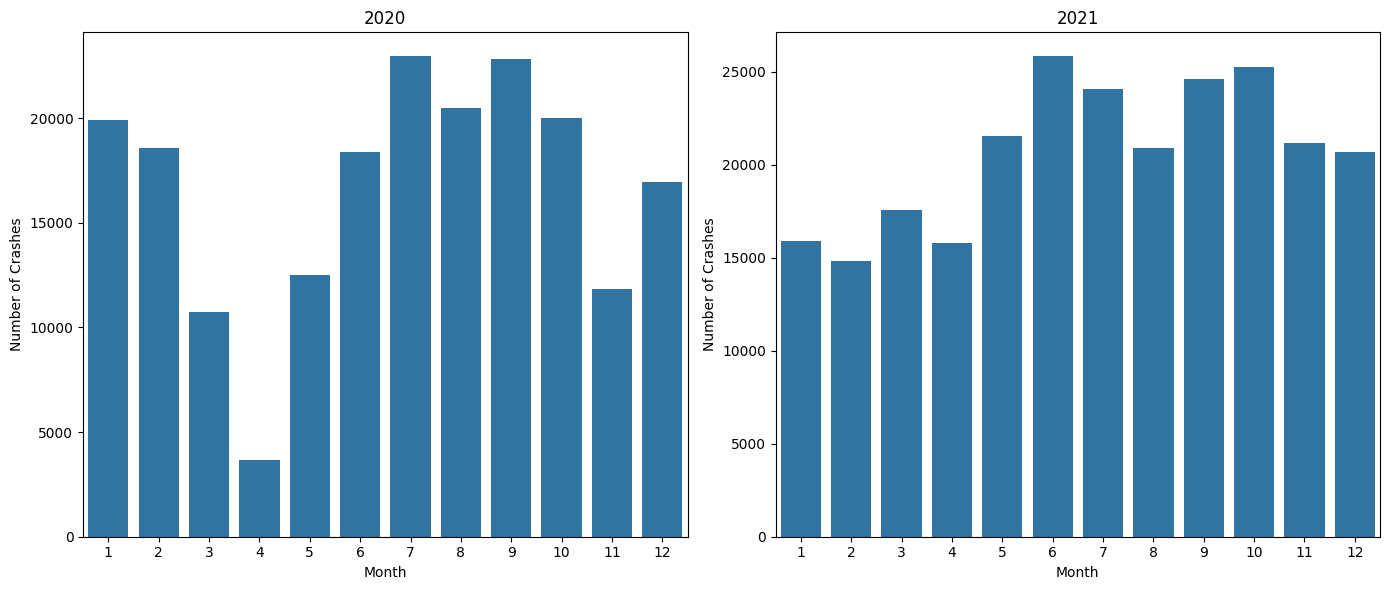

In [22]:
dfs = [BAAC_table_2020, BAAC_table_2021]
graph_baac.plot_multiple(dfs, graph_baac.plot_crashes_per_month, ['2020', '2021'])

A remplir

On a plot l'histogramme du nombre de victimes par mois sur une année pour les années 2020 et 2021
Les creux correspondent précisement aux confinements liés au COVID. Les histogrammes associés aux autres années sont plus réguliers. Globalement, l'évolution temporelle des variables est faible. 

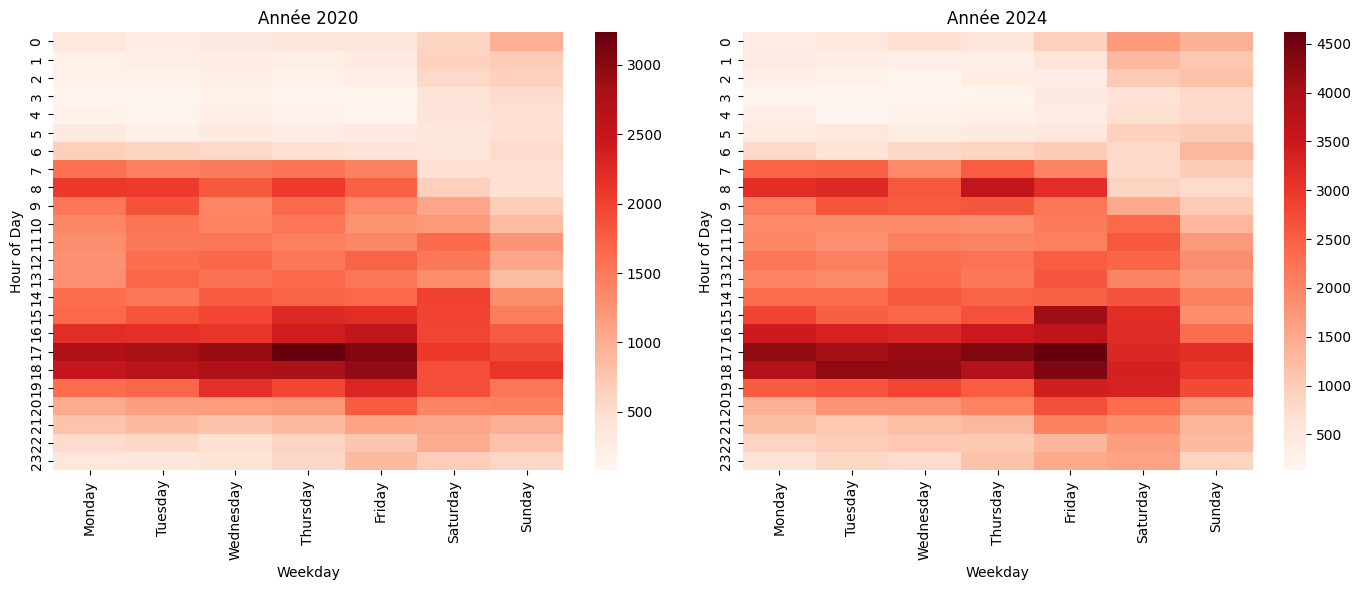

In [23]:
dfs = [BAAC_table_2020, BAAC_table_2024]
graph_baac.plot_multiple(dfs, graph_baac.plot_accidents_heatmap_cote_a_cote, ['Année 2020', 'Année 2024'])

A remplir

Si l'on observe une différence en termes de quantité de victimes d'accident de la route, la fréquence d'accident par jour de la semaine et heure de la journée reste similaire. Les pics par heure correspondent aux pics de fatigue du corps humain (théoriquement 5h et 16h, ici plutôt 7/8h et 16/17h, ce qui correspond aux horaires de travail) avec un pic le vendredi en fin de semaine et une diminution nette le week-end.

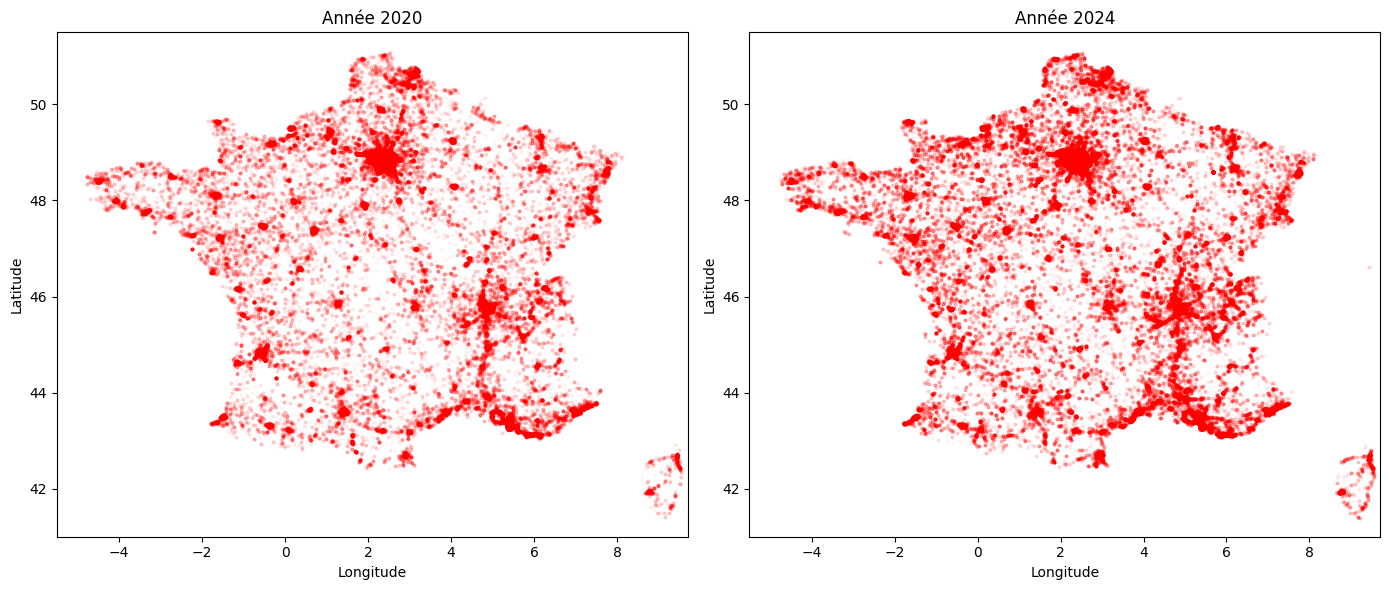

In [24]:
titles = ['Année 2020', 'Année 2024']
graph_baac.plot_multiple(dfs, graph_baac.plot_crashes_heatmap_cote_a_cote, titles)

A remplir

Enfin, cette heatmap permet de finir de constater que le nombre a augmenté au cours des 5 dernières années, mais la répartition est globalement la même. C'est pourquoi dans la suite de l'étde on se concentrera sur le dataset lié à l'année 2024.

## II. Analyse exploratoire multivariée  

A remplir

L'objectif principal de ce projet est de comprendre les facteurs liés au risque d'accident sur la route. On se propose dans un premier temps d'observer les données de manière exploratoire à l'aide d'analyses en composantes principales. Dans un premier temps en conservant toutes les variables, puis en extrayant les variables expliquant le mieux la variance, et en les combinant avec les variables que l'on considère pertinentes pour observer les corrélations entre elles. Enfin on effectuera une régression multivariée afin d'exliquer la gravité de l'accident. 

### ACP prenant en compte toutes les variables

Explained variance ratio:
[0.16678299 0.09256485 0.0858053 ]
Cumulative variance explained:
[0.16678299 0.25934784 0.34515314]


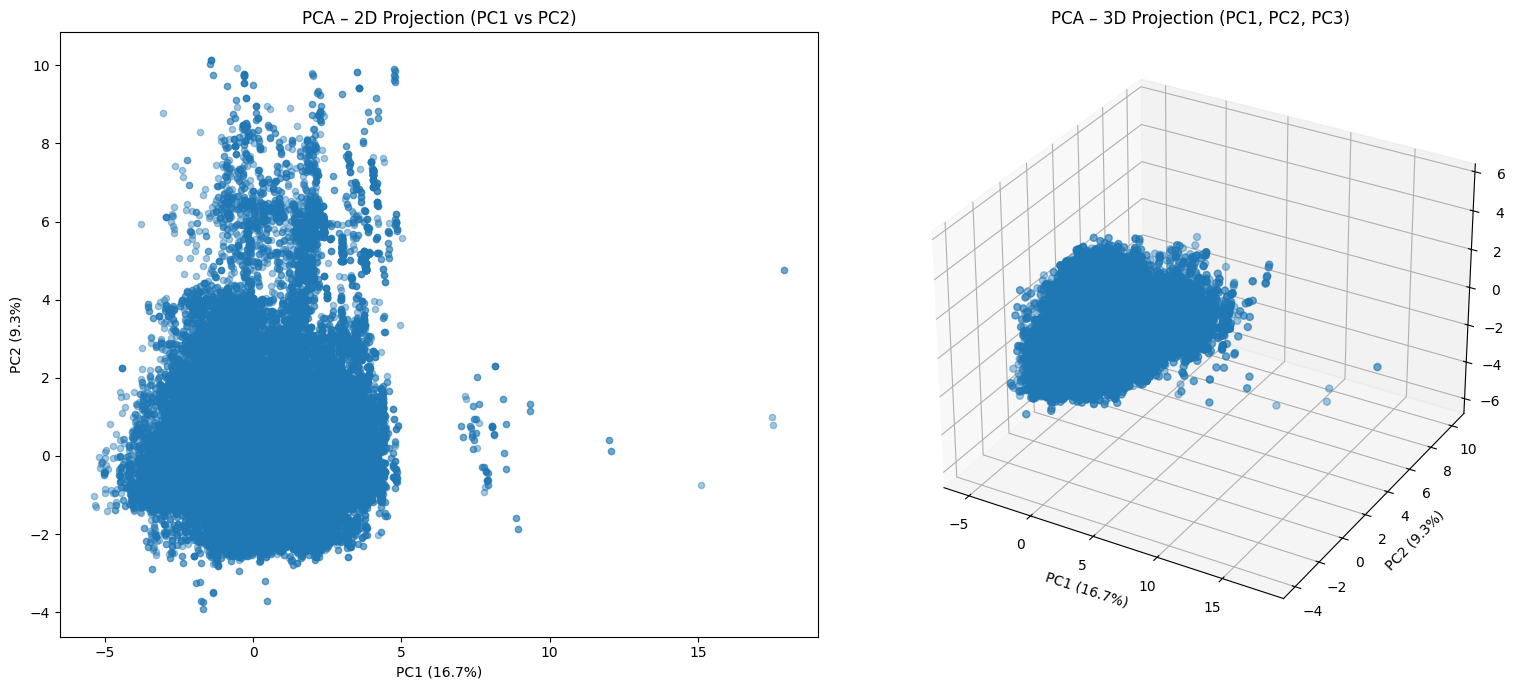

In [25]:
pca, pca_df = graph_baac.plot_pca_2D_3D(BAAC_table_2024)

A remplir

wtf

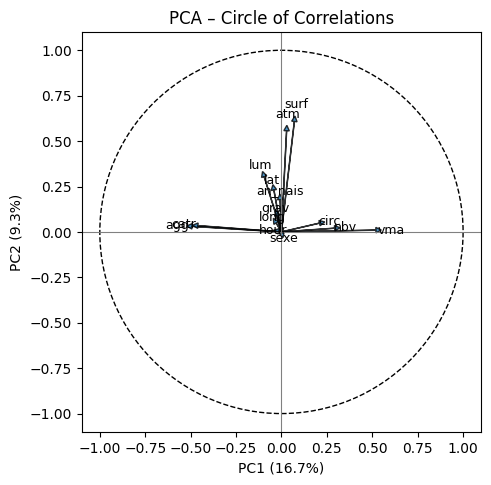

In [26]:
graph_baac.plot_correlation_circle(pca, pca_df.columns)

In [27]:
a, b, significant_variables = graph_baac.pca_analysis(pca, pca_df, 0.1)

Correlation of variables with PCs:
           PC1    PC2    PC3
grav    -0.047  0.136  0.251
hour    -0.067  0.011  0.288
lat     -0.072  0.296 -0.112
long    -0.068  0.086 -0.029
agg     -0.798  0.037  0.140
vma      0.840  0.012  0.011
nbv      0.493  0.026  0.347
catr    -0.748  0.042  0.010
circ     0.365  0.063  0.267
lum     -0.159  0.379  0.566
atm      0.046  0.668 -0.349
surf     0.114  0.726 -0.212
sexe     0.014 -0.035 -0.021
an_nais -0.013  0.236  0.586

Cos² (quality of representation):
           PC1    PC2    PC3  sum_PC1_PC2
grav     0.002  0.018  0.063        0.021
hour     0.004  0.000  0.083        0.005
lat      0.005  0.088  0.013        0.093
long     0.005  0.007  0.001        0.012
agg      0.636  0.001  0.020        0.638
vma      0.706  0.000  0.000        0.706
nbv      0.243  0.001  0.120        0.244
catr     0.560  0.002  0.000        0.562
circ     0.133  0.004  0.071        0.137
lum      0.025  0.144  0.320        0.169
atm      0.002  0.446  0.122     

A remplir

Constater les oppositions entre variables, et observer les variables contribuant beaucoup aux composantes principales
Bien préciser que les variables contribuant peu ne sont pas inintéressantes, et qu'il est logique que des variables pouvant prendre plus de valeurs que celles qui nous intéressent telles que la gravité (4) ou encore le sexe (2) soient de norme faible puisque leur variance sera naturellement plus faible que celle d'une autre comme la vitesse maximale autorisée. 

In [28]:
BAAC_table_2024.columns

Index(['Num_Acc', 'grav', 'year', 'mois', 'jour', 'hour', 'lat', 'long', 'dep',
       'agg', 'vma', 'nbv', 'catr', 'circ', 'lum', 'atm', 'surf', 'sexe',
       'an_nais', 'date', 'weekday'],
      dtype='object')

### ACP ciblée

A remplir

On se concentre maintenant sur certaines variables " "

Explained variance ratio:
[0.3237807  0.22163861 0.20157394]
Cumulative variance explained:
[0.3237807  0.54541931 0.74699325]


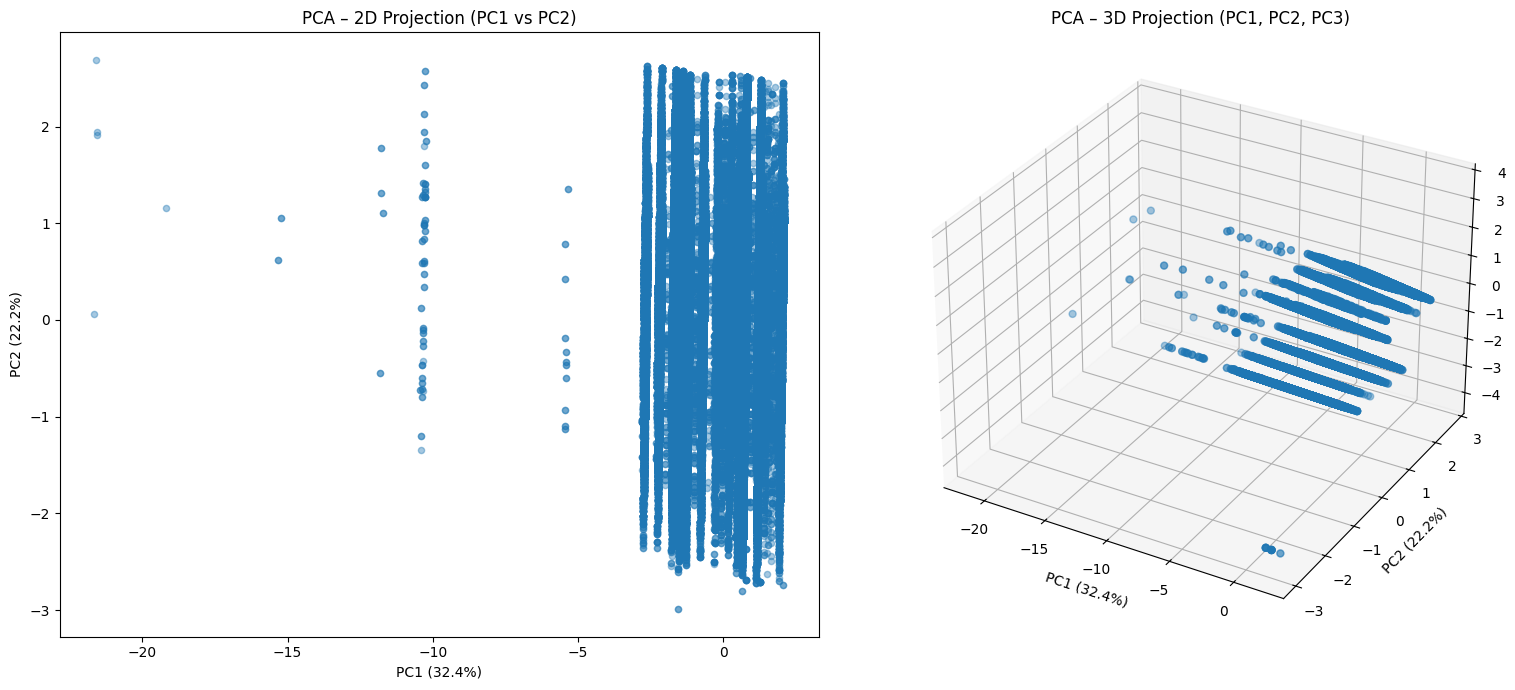

In [29]:
pca_s, pca_df_s = graph_baac.plot_pca_2D_3D(BAAC_table_2024, ['an_nais', 'grav', 'vma', 'sexe', 'agg'])

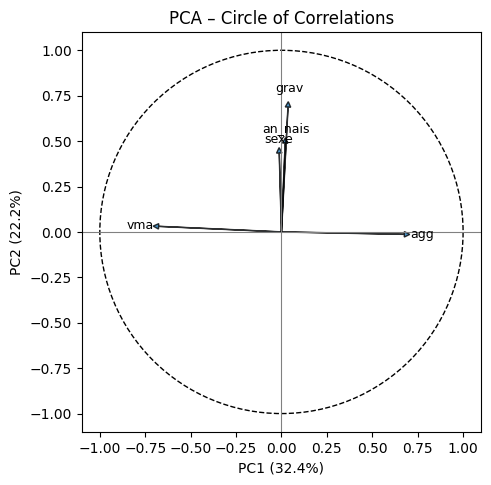

In [30]:
graph_baac.plot_correlation_circle(pca_s, pca_df_s.columns)

A remplir

La vitesse maximale autorisée est opposée au fait d'habiter en agglomération. La gravité de l'accident est positivement corrélée au sexe, et à l'année de naissance, ce qui signifie que les jeunes sont plus gravement touchés. 

Sur la représentation graphique de l'ACP, les individus sont répartis en plans parallèles, cela est du à la nature discrète de certaines variables.

In [31]:
model = graph_baac.run_regression(BAAC_table_2024, ['grav', 'an_nais', 'vma', 'sexe', 'agg', 'lum', 'atm', 'surf'])

                            OLS Regression Results                            
Dep. Variable:                   grav   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     592.7
Date:                Fri, 02 Jan 2026   Prob (F-statistic):               0.00
Time:                        19:04:28   Log-Likelihood:            -5.2459e+05
No. Observations:              300663   AIC:                         1.049e+06
Df Residuals:                  300655   BIC:                         1.049e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.7646      0.268    -36.432      0.0

A remplir

La régression n'a aucun sens

info sur "https://odisse.santepubliquefrance.fr/explore/dataset/alcool-consommation-quotidienne-region/information/?sort=annee"
et "https://odisse.santepubliquefrance.fr/explore/dataset/alcool-alcoolisation-ponctuelle-importante-api-mensuel-et-hebdomadaire-region/export/"

In [133]:
# Chargement en dataframes
df_conso = module_region.prepare_alc(pd.read_csv(URL_CONSO, sep=';'), "alc_quo")
df_api   = module_region.prepare_alc(pd.read_csv(URL_API, sep=';'), "alc_bim")
df_conso = df_conso.merge(df_api,on=["region", "region_id"],how="inner")
print(df_conso.columns)
df_conso

Index(['region_id', 'region', 'alc_quo_F_2000', 'alc_quo_F_2005',
       'alc_quo_F_2010', 'alc_quo_F_2014', 'alc_quo_F_2017', 'alc_quo_F_2021',
       'alc_quo_HF_2000', 'alc_quo_HF_2005', 'alc_quo_HF_2010',
       'alc_quo_HF_2014', 'alc_quo_HF_2017', 'alc_quo_HF_2021',
       'alc_quo_H_2000', 'alc_quo_H_2005', 'alc_quo_H_2010', 'alc_quo_H_2014',
       'alc_quo_H_2017', 'alc_quo_H_2021', 'alc_bim_F_2005', 'alc_bim_F_2010',
       'alc_bim_F_2014', 'alc_bim_F_2017', 'alc_bim_F_2021', 'alc_bim_HF_2005',
       'alc_bim_HF_2010', 'alc_bim_HF_2014', 'alc_bim_HF_2017',
       'alc_bim_HF_2021', 'alc_bim_H_2005', 'alc_bim_H_2010', 'alc_bim_H_2014',
       'alc_bim_H_2017', 'alc_bim_H_2021'],
      dtype='object')


,region_id,region,alc_quo_F_2000,alc_quo_F_2005,alc_quo_F_2010,alc_quo_F_2014,alc_quo_F_2017,alc_quo_F_2021,alc_quo_HF_2000,alc_quo_HF_2005,...,alc_bim_HF_2005,alc_bim_HF_2010,alc_bim_HF_2014,alc_bim_HF_2017,alc_bim_HF_2021,alc_bim_H_2005,alc_bim_H_2010,alc_bim_H_2014,alc_bim_H_2017,alc_bim_H_2021
0,0,Outre mer,NaN,NaN,NaN,NaN,NaN,7.7,NaN,NaN,...,NaN,NaN,NaN,NaN,61.5,NaN,NaN,NaN,NaN,190.8
1,11,Île-de-France,16.2914,7.6751,5.5453,4.6628,4.1522,3.1,22.3674,13.5796,...,11.6856,15.4722,14.6944,13.8817,14.6,17.6970,23.6380,20.4132,21.3987,22.6
2,24,Centre-Val de Loire,11.0433,6.6620,4.2052,6.9995,4.7400,3.9,19.5600,13.9200,...,15.2475,16.5377,19.9025,15.9031,15.7,26.2494,27.6228,28.8566,25.8766,22.8
3,27,Bourgogne et Franche-Comté,9.6263,5.7699,3.9404,4.9227,5.4705,2.3,18.3226,13.4990,...,15.8126,17.5635,22.9706,16.9204,17.3,24.0286,28.2452,37.4743,28.3465,35.6
4,28,Normandie,8.1800,5.2697,5.1457,2.2600,3.1412,2.4,15.6665,12.4138,...,14.2575,16.5681,15.6911,16.1928,16.5,23.5423,26.6439,25.0977,25.4299,31.7
5,32,Hauts-de-France,11.4334,8.2256,5.0741,4.6270,5.5998,3.0,21.1408,16.6569,...,14.5865,17.9911,17.6234,14.9562,14.6,23.0988,28.7818,27.4232,22.4849,25.9
6,44,Grand Est,10.1625,8.0550,3.9585,4.4614,5.6741,2.5,20.9672,15.4670,...,15.0181,17.4817,14.9872,15.1868,15.6,24.5923,28.6822,23.2676,24.3693,23.9
7,52,Pays de la Loire,11.9235,6.6822,5.9050,3.3325,3.0609,4.3,22.0372,14.4345,...,17.8056,25.0850,22.6914,17.5163,22.4,29.5638,42.7714,33.1051,29.0432,25.2
8,53,Bretagne,10.1168,7.6276,5.3632,4.4697,3.5681,3.5,20.6910,14.0558,...,17.5586,20.4807,22.3532,20.4934,22.2,28.4187,32.9570,34.8660,32.4442,24.3
9,75,Nouvelle Aquitaine,14.0312,8.6806,5.5701,5.6284,6.0304,5.1,26.3976,16.1890,...,16.8181,19.0057,16.2874,16.8547,16.7,27.7498,30.0163,27.1546,26.2830,5.2


In [127]:
response = requests.get(url_impot)
raw_df1 = pd.read_excel(BytesIO(response.content), sheet_name='regional_nombres')
raw_df2 = pd.read_excel(BytesIO(response.content), sheet_name='regional_montants')

# Fix headers and basic normalization
df1 = module_region.excel_fix(raw_df1)
df2 = module_region.excel_fix(raw_df2)

# population = foyers_{year}, montants = montants_{year}
df1_fixed = module_region._prefix_year_cols(df1, 'foyers')
df2_fixed = module_region._prefix_year_cols(df2, 'montants')

df2_fixed

,region_id,region,montants_2014,montants_2015,montants_2016,montants_2017,montants_2018,montants_2019,montants_2020,montants_2021,montants_2022,montants_2023
0,11,ÎLE-DE-FRANCE,24428.6,25745.2,25250.2,26011.4,28162.4,27823.9,26744.4,28949,29743,30191
1,24,CENTRE-VAL DE LOIRE,2136.8,2124.0,2022.5,1976.4,2123.5,2106.8,1995.3,2159,2188,2212
2,27,BOURGOGNE-FRANCHE-COMTÉ,2293.9,2337.3,2231.8,2190.8,2369.4,2363.3,2226.2,2434,2455,2559
3,28,NORMANDIE,2589.9,2626.0,2500.7,2481.5,2653.3,2650.9,2550,2758,2737,2841
4,32,HAUTS DE FRANCE,4336.5,4480.7,4235.2,4240.0,4640.1,4546,4372.4,4743,4738,4847
5,44,GRAND EST,4863.5,4954.4,4736.6,4757.5,5097.6,5045.3,4830.4,5169,5208,5397
6,52,PAYS DE LA LOIRE,2672.2,2762.2,2649.0,2673.8,2947.5,2998.5,2886.3,3179,3209,3221
7,53,BRETAGNE,2500.6,2586.5,2448.1,2462.2,2716.2,2730.6,2636.6,2946,2933,3038
8,75,NOUVELLE AQUITAINE,4903.5,5044.8,4743.4,4783.0,5195.8,5162.1,5028.2,5556,5568,5593
9,76,OCCITANIE,4784.4,4992.8,4655.1,4737.6,5133.2,5121.1,4927.2,5460,5342,5371


On a enlevé les résidents étrangers et la ligne du total

In [157]:
richesse_df = module_region.compute_richesse(df1_fixed, df2_fixed, keys=("region_id", "region"))
print(richesse_df.columns)
richesse_df


Index(['region_id', 'region', 'foyers_2014', 'foyers_2015', 'foyers_2016',
       'foyers_2017', 'foyers_2018', 'foyers_2019', 'foyers_2020',
       'foyers_2021', 'foyers_2022', 'foyers_2023', 'montants_2014',
       'montants_2015', 'montants_2016', 'montants_2017', 'montants_2018',
       'montants_2019', 'montants_2020', 'montants_2021', 'montants_2022',
       'montants_2023', 'richesse_2014', 'richesse_2015', 'richesse_2016',
       'richesse_2017', 'richesse_2018', 'richesse_2019', 'richesse_2020',
       'richesse_2021', 'richesse_2022', 'richesse_2023'],
      dtype='object')


,region_id,region,foyers_2014,foyers_2015,foyers_2016,foyers_2017,foyers_2018,foyers_2019,foyers_2020,foyers_2021,...,richesse_2014,richesse_2015,richesse_2016,richesse_2017,richesse_2018,richesse_2019,richesse_2020,richesse_2021,richesse_2022,richesse_2023
0,11,ÎLE-DE-FRANCE,6770.6,6809.9,6831.3,6907.2,6978.2,7152.0,7241.9,7247.0,...,3.608041,3.780555,3.696251,3.765839,4.035769,3.890366,3.693009,3.994618,4.068810,4.064486
1,24,CENTRE-VAL DE LOIRE,1448.5,1455.2,1464.0,1481.5,1476.3,1494.1,1506.0,1520.0,...,1.475181,1.459593,1.381489,1.334053,1.438393,1.410080,1.324900,1.420395,1.429131,1.433571
2,27,BOURGOGNE-FRANCHE-COMTÉ,1586.4,1590.8,1592.0,1598.6,1598.1,1618.9,1634.8,1643.0,...,1.445978,1.469261,1.401884,1.370449,1.482636,1.459818,1.361757,1.481436,1.478916,1.535093
3,28,NORMANDIE,1857.8,1865.0,1868.0,1877.3,1881.6,1912.9,1936.2,1954.0,...,1.394068,1.408043,1.338704,1.321845,1.410130,1.385802,1.317013,1.411464,1.387228,1.429794
4,32,HAUTS DE FRANCE,3261.9,3273.2,3278.0,3302.9,3297.6,3345.1,3383.5,3409.0,...,1.329440,1.368905,1.292007,1.283720,1.407114,1.359003,1.292271,1.391317,1.379732,1.402894
5,44,GRAND EST,3054.6,3065.4,3075.2,3097.7,3120.9,3155.6,3182.2,3194.0,...,1.592189,1.616233,1.540258,1.535817,1.633375,1.598840,1.517944,1.618347,1.620915,1.668831
6,52,PAYS DE LA LOIRE,2004.3,2026.3,2045.4,2075.8,2095.9,2143.8,2181.1,2210.0,...,1.333234,1.363174,1.295101,1.288082,1.406317,1.398685,1.323323,1.438462,1.430036,1.419568
7,53,BRETAGNE,1824.8,1842.4,1857.5,1884.9,1894.8,1935.9,1971.5,2006.0,...,1.370342,1.403875,1.317954,1.306276,1.433502,1.410507,1.337357,1.468594,1.440570,1.473327
8,75,NOUVELLE AQUITAINE,3404.1,3433.7,3463.4,3518.7,3530.4,3604.3,3663.8,3715.0,...,1.440469,1.469202,1.369579,1.359309,1.471731,1.432206,1.372400,1.495559,1.478492,1.469908
9,76,OCCITANIE,3311.9,3338.8,3367.1,3424.1,3456.4,3539.2,3604.5,3664.0,...,1.444609,1.495388,1.382525,1.383604,1.485129,1.446965,1.366958,1.490175,1.431404,1.421652


In [ ]:
df = BAAC_table_norm.copy()
BAAC_table_region = module_region.clean_BAAC_region(df)
BAAC_table_region = module_region.reshape_BAAC_region(BAAC_table_region)
print(BAAC_table_region.columns)
BAAC_table_region
# il manque la corse

Index(['region_id', 'region', 'avg_an_nais_2020_F', 'avg_an_nais_2020_H',
       'avg_an_nais_2021_F', 'avg_an_nais_2021_H', 'avg_an_nais_2022_F',
       'avg_an_nais_2022_H', 'avg_an_nais_2023_F', 'avg_an_nais_2023_H',
       'avg_an_nais_2024_F', 'avg_an_nais_2024_H', 'avg_grav_2020_F',
       'avg_grav_2020_H', 'avg_grav_2021_F', 'avg_grav_2021_H',
       'avg_grav_2022_F', 'avg_grav_2022_H', 'avg_grav_2023_F',
       'avg_grav_2023_H', 'avg_grav_2024_F', 'avg_grav_2024_H',
       'sum_acc_2020_F', 'sum_acc_2020_H', 'sum_acc_2021_F', 'sum_acc_2021_H',
       'sum_acc_2022_F', 'sum_acc_2022_H', 'sum_acc_2023_F', 'sum_acc_2023_H',
       'sum_acc_2024_F', 'sum_acc_2024_H'],
      dtype='object')


,region_id,region,avg_an_nais_2020_F,avg_an_nais_2020_H,avg_an_nais_2021_F,avg_an_nais_2021_H,avg_an_nais_2022_F,avg_an_nais_2022_H,avg_an_nais_2023_F,avg_an_nais_2023_H,...,sum_acc_2020_F,sum_acc_2020_H,sum_acc_2021_F,sum_acc_2021_H,sum_acc_2022_F,sum_acc_2022_H,sum_acc_2023_F,sum_acc_2023_H,sum_acc_2024_F,sum_acc_2024_H
0,1,Outre mer,1983.642940,1983.092197,1984.825303,1984.551772,1985.441507,1985.276708,1986.216495,1985.577744,...,3428.0,7907.0,4047.0,8723.0,4274.0,8743.0,5628.0,11210.0,5945.0,11629.0
1,11,Île-de-France,1982.804911,1982.603853,1984.173289,1983.990750,1985.237636,1984.328408,1985.641697,1985.171985,...,16818.0,44481.0,19730.0,53196.0,19501.0,51840.0,24451.0,67889.0,24549.0,64304.0
2,24,Centre-Val de Loire,1978.837256,1981.497980,1982.528850,1983.077901,1982.315689,1983.634008,1984.920266,1985.453096,...,1997.0,3960.0,2617.0,4878.0,2626.0,4748.0,3612.0,6531.0,3365.0,6628.0
3,27,Bourgogne-Franche-Comté,1978.732856,1980.964740,1982.193926,1981.571044,1980.275258,1982.059720,1981.743232,1984.546740,...,1677.0,3460.0,2305.0,4462.0,2227.0,4722.0,3509.0,6016.0,3424.0,6493.0
4,28,Normandie,1979.780551,1982.061860,1980.867407,1983.044610,1982.729745,1983.648086,1982.726956,1983.993755,...,2684.0,4882.0,3243.0,6299.0,3493.0,6300.0,4882.0,8647.0,4704.0,8693.0
5,32,Hauts-de-France,1982.304531,1983.074027,1983.104184,1984.794598,1984.186702,1984.352315,1985.178228,1985.578309,...,2847.0,6322.0,3561.0,7405.0,3761.0,7907.0,4786.0,9602.0,4459.0,9677.0
6,44,Grand Est,1980.987034,1981.673817,1981.554548,1982.555930,1983.009886,1983.132308,1983.871874,1984.448449,...,3702.0,7692.0,4409.0,8913.0,4653.0,8912.0,6119.0,11180.0,5692.0,11304.0
7,52,Pays de la Loire,1979.417815,1981.257227,1980.866667,1983.856636,1982.146142,1984.415650,1983.338796,1985.302837,...,2032.0,4082.0,2655.0,5357.0,2696.0,5332.0,3905.0,7551.0,4092.0,7900.0
8,53,Bretagne,1979.061994,1981.619104,1982.348608,1983.113560,1981.273850,1983.001853,1981.563762,1982.999768,...,2839.0,5025.0,3557.0,6261.0,3565.0,6482.0,4909.0,8650.0,4233.0,7965.0
9,75,Nouvelle-Aquitaine,1979.821730,1980.007250,1981.292704,1981.979283,1981.572979,1982.046346,1982.646950,1983.191191,...,5688.0,10897.0,7113.0,13035.0,6543.0,12197.0,8628.0,15938.0,8598.0,15497.0


In [162]:
BAAC_table_region = module_region.fix_region(BAAC_table_region)
df_conso = module_region.fix_region(df_conso)
richesse_df = module_region.fix_region(richesse_df)
region_df = BAAC_table_region.merge(df_conso, on=["region", "region_id"])
region_df = region_df.merge(richesse_df, on=["region", "region_id"])
print(region_df.columns)
region_df

Index(['region_id', 'region', 'avg_an_nais_2020_F', 'avg_an_nais_2020_H',
       'avg_an_nais_2021_F', 'avg_an_nais_2021_H', 'avg_an_nais_2022_F',
       'avg_an_nais_2022_H', 'avg_an_nais_2023_F', 'avg_an_nais_2023_H',
       'avg_an_nais_2024_F', 'avg_an_nais_2024_H', 'avg_grav_2020_F',
       'avg_grav_2020_H', 'avg_grav_2021_F', 'avg_grav_2021_H',
       'avg_grav_2022_F', 'avg_grav_2022_H', 'avg_grav_2023_F',
       'avg_grav_2023_H', 'avg_grav_2024_F', 'avg_grav_2024_H',
       'sum_acc_2020_F', 'sum_acc_2020_H', 'sum_acc_2021_F', 'sum_acc_2021_H',
       'sum_acc_2022_F', 'sum_acc_2022_H', 'sum_acc_2023_F', 'sum_acc_2023_H',
       'sum_acc_2024_F', 'sum_acc_2024_H', 'alc_quo_F_2000', 'alc_quo_F_2005',
       'alc_quo_F_2010', 'alc_quo_F_2014', 'alc_quo_F_2017', 'alc_quo_F_2021',
       'alc_quo_HF_2000', 'alc_quo_HF_2005', 'alc_quo_HF_2010',
       'alc_quo_HF_2014', 'alc_quo_HF_2017', 'alc_quo_HF_2021',
       'alc_quo_H_2000', 'alc_quo_H_2005', 'alc_quo_H_2010', 'alc_quo_H_20

,region_id,region,avg_an_nais_2020_F,avg_an_nais_2020_H,avg_an_nais_2021_F,avg_an_nais_2021_H,avg_an_nais_2022_F,avg_an_nais_2022_H,avg_an_nais_2023_F,avg_an_nais_2023_H,...,richesse_2014,richesse_2015,richesse_2016,richesse_2017,richesse_2018,richesse_2019,richesse_2020,richesse_2021,richesse_2022,richesse_2023
0,1,OUTRE-MER,1983.642940,1983.092197,1984.825303,1984.551772,1985.441507,1985.276708,1986.216495,1985.577744,...,0.742348,0.795190,0.730689,0.751413,0.894886,0.860583,0.816090,0.873499,0.858372,0.862202
1,11,ÎLE-DE-FRANCE,1982.804911,1982.603853,1984.173289,1983.990750,1985.237636,1984.328408,1985.641697,1985.171985,...,3.608041,3.780555,3.696251,3.765839,4.035769,3.890366,3.693009,3.994618,4.068810,4.064486
2,24,CENTRE-VAL DE LOIRE,1978.837256,1981.497980,1982.528850,1983.077901,1982.315689,1983.634008,1984.920266,1985.453096,...,1.475181,1.459593,1.381489,1.334053,1.438393,1.410080,1.324900,1.420395,1.429131,1.433571
3,27,BOURGOGNE-FRANCHE-COMTÉ,1978.732856,1980.964740,1982.193926,1981.571044,1980.275258,1982.059720,1981.743232,1984.546740,...,1.445978,1.469261,1.401884,1.370449,1.482636,1.459818,1.361757,1.481436,1.478916,1.535093
4,28,NORMANDIE,1979.780551,1982.061860,1980.867407,1983.044610,1982.729745,1983.648086,1982.726956,1983.993755,...,1.394068,1.408043,1.338704,1.321845,1.410130,1.385802,1.317013,1.411464,1.387228,1.429794
5,32,HAUTS DE FRANCE,1982.304531,1983.074027,1983.104184,1984.794598,1984.186702,1984.352315,1985.178228,1985.578309,...,1.329440,1.368905,1.292007,1.283720,1.407114,1.359003,1.292271,1.391317,1.379732,1.402894
6,44,GRAND EST,1980.987034,1981.673817,1981.554548,1982.555930,1983.009886,1983.132308,1983.871874,1984.448449,...,1.592189,1.616233,1.540258,1.535817,1.633375,1.598840,1.517944,1.618347,1.620915,1.668831
7,52,PAYS DE LA LOIRE,1979.417815,1981.257227,1980.866667,1983.856636,1982.146142,1984.415650,1983.338796,1985.302837,...,1.333234,1.363174,1.295101,1.288082,1.406317,1.398685,1.323323,1.438462,1.430036,1.419568
8,53,BRETAGNE,1979.061994,1981.619104,1982.348608,1983.113560,1981.273850,1983.001853,1981.563762,1982.999768,...,1.370342,1.403875,1.317954,1.306276,1.433502,1.410507,1.337357,1.468594,1.440570,1.473327
9,75,NOUVELLE AQUITAINE,1979.821730,1980.007250,1981.292704,1981.979283,1981.572979,1982.046346,1982.646950,1983.191191,...,1.440469,1.469202,1.369579,1.359309,1.471731,1.432206,1.372400,1.495559,1.478492,1.469908


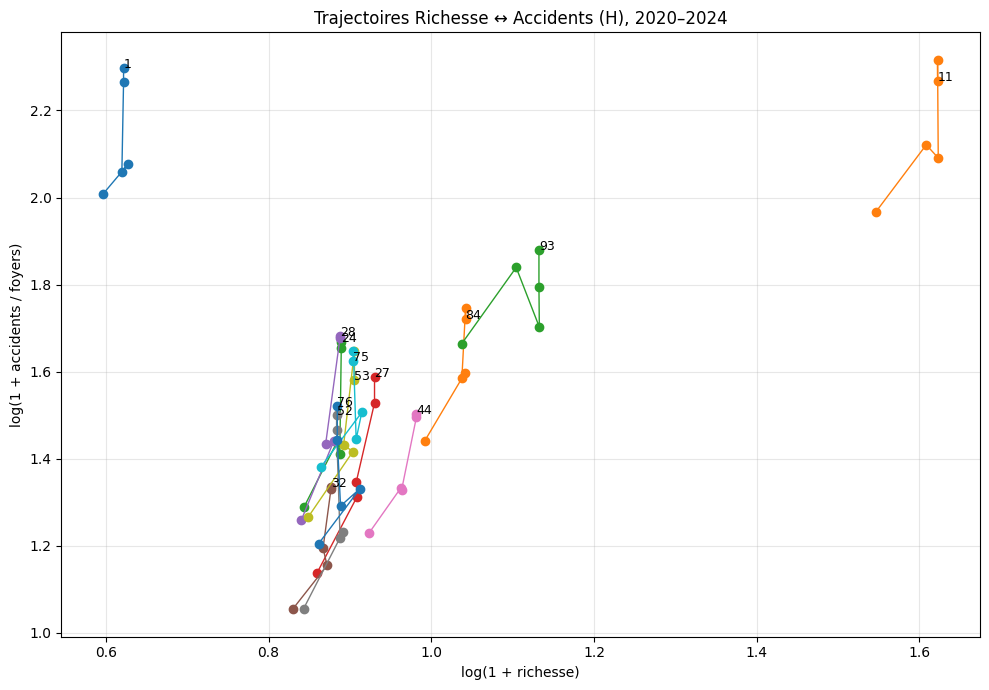

In [163]:
graph_region.plot_richesse_accidents_trajectories(region_df)

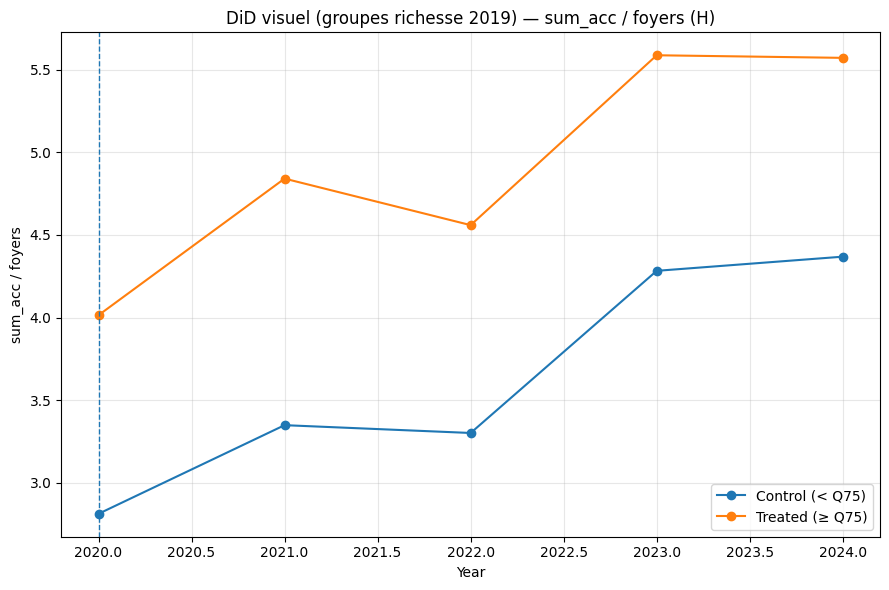

In [164]:
graph_region.plot_did_covid(region_df)

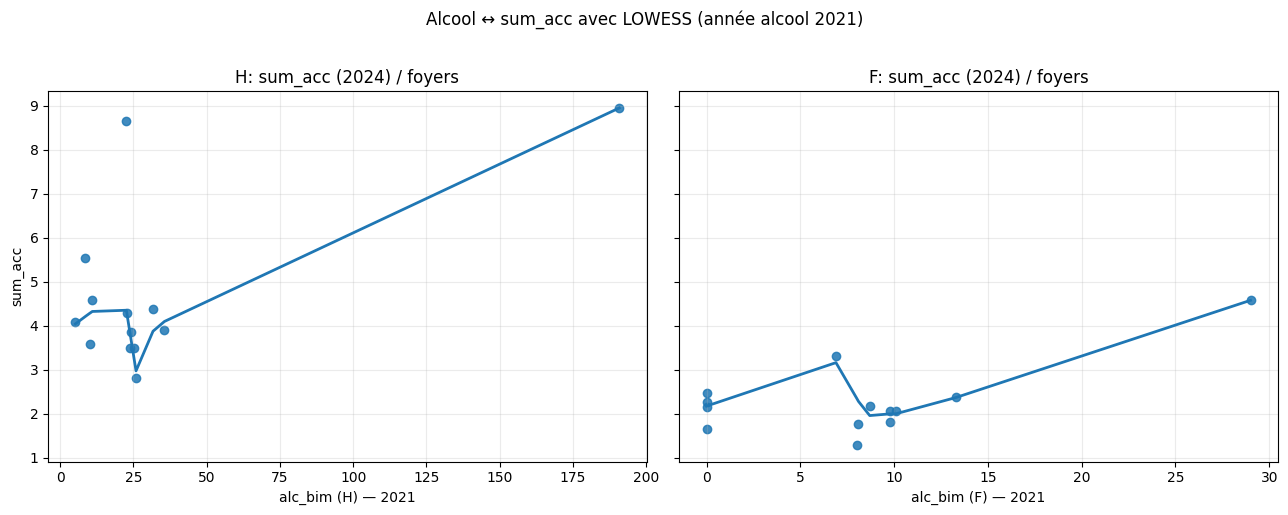

In [165]:
graph_region.plot_alcohol_accidents_lowess(region_df)

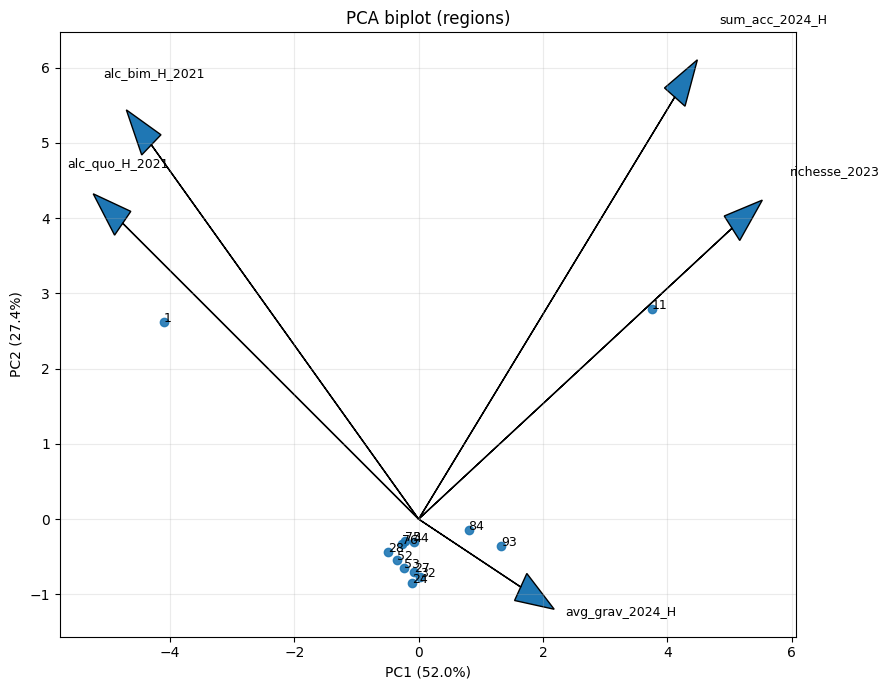

,"n_components n_components: int, float or 'mle', default=NoneNumber of components to keep.if n_components is not set all components are kept:: n_components == min(n_samples, n_features)If ``n_components == 'mle'`` and ``svd_solver == 'full'``, Minka'sMLE is used to guess the dimension. Use of ``n_components == 'mle'``will interpret ``svd_solver == 'auto'`` as ``svd_solver == 'full'``.If ``0 < n_components < 1`` and ``svd_solver == 'full'``, select thenumber of components such that the amount of variance that needs to beexplained is greater than the percentage specified by n_components.If ``svd_solver == 'arpack'``, the number of components must bestrictly less than the minimum of n_features and n_samples.Hence, the None case results in:: n_components == min(n_samples, n_features) - 1",2
,"copy copy: bool, default=TrueIf False, data passed to fit are overwritten and runningfit(X).transform(X) will not yield the expected results,use fit_transform(X) instead.",True
,"whiten whiten: bool, default=FalseWhen True (False by default) the `components_` vectors are multipliedby the square root of n_samples and then divided by the singular valuesto ensure uncorrelated outputs with unit component-wise variances.Whitening will remove some information from the transformed signal(the relative variance scales of the components) but can sometimeimprove the predictive accuracy of the downstream estimators bymaking their data respect some hard-wired assumptions.",False
,"svd_solver svd_solver: {'auto', 'full', 'covariance_eigh', 'arpack', 'randomized'}, default='auto'""auto"" : The solver is selected by a default 'auto' policy is based on `X.shape` and `n_components`: if the input data has fewer than 1000 features and more than 10 times as many samples, then the ""covariance_eigh"" solver is used. Otherwise, if the input data is larger than 500x500 and the number of components to extract is lower than 80% of the smallest dimension of the data, then the more efficient ""randomized"" method is selected. Otherwise the exact ""full"" SVD is computed and optionally truncated afterwards.""full"" : Run exact full SVD calling the standard LAPACK solver via `scipy.linalg.svd` and select the components by postprocessing""covariance_eigh"" : Precompute the covariance matrix (on centered data), run a classical eigenvalue decomposition on the covariance matrix typically using LAPACK and select the components by postprocessing. This solver is very efficient for n_samples >> n_features and small n_features. It is, however, not tractable otherwise for large n_features (large memory footprint required to materialize the covariance matrix). Also note that compared to the ""full"" solver, this solver effectively doubles the condition number and is therefore less numerical stable (e.g. on input data with a large range of singular values).""arpack"" : Run SVD truncated to `n_components` calling ARPACK solver via `scipy.sparse.linalg.svds`. It requires strictly `0 < n_components < min(X.shape)`""randomized"" : Run randomized SVD by the method of Halko et al... versionadded:: 0.18.0.. versionchanged:: 1.5 Added the 'covariance_eigh' solver.",'auto'
,"tol tol: float, default=0.0Tolerance for singular values computed by svd_solver == 'arpack'.Must be of range [0.0, infinity)... versionadded:: 0.18.0",0.0
,"iterated_power iterated_power: int or 'auto', default='auto'Number of iterations for the power method computed bysvd_solver == 'randomized'.Must be of range [0, infinity)... versionadded:: 0.18.0",'auto'
,"n_oversamples n_oversamples: int, default=10This parameter is only relevant when `svd_solver=""randomized""`.It corresponds to the additional number of random vectors to sample therange of `X` so as to ensure proper conditioning. See:func:`~sklearn.utils.extmath.randomized_svd` for more details... versionadded:: 1.1",10
,"power_iteration_normalizer power_iteration_normalizer: {'auto', 'QR', 'LU', 'none'}, default='auto'Power iteration normalizer for randomized SVD 

In [ ]:
features = ["richesse_2023", "alc_bim_H_2021", "alc_quo_H_2021", "avg_grav_2024_H", "sum_acc_2024_H"]
graph_region.plot_pca_biplot(region_df, features = features)

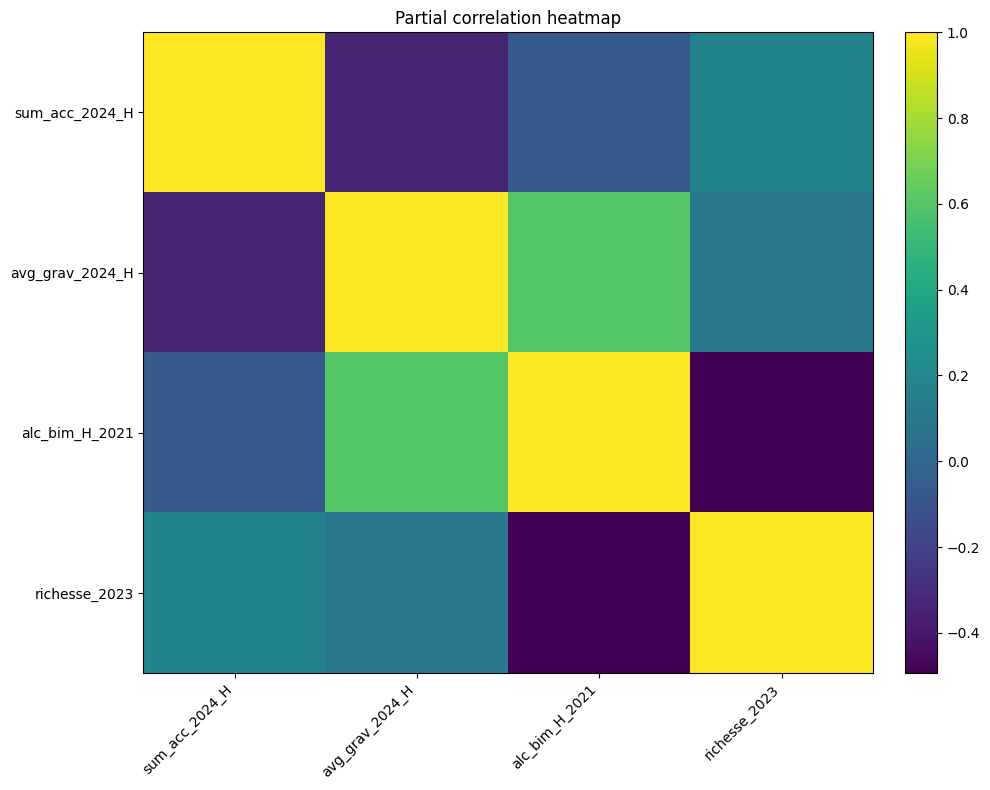

,sum_acc_2024_H,avg_grav_2024_H,alc_bim_H_2021,richesse_2023
sum_acc_2024_H,1.000000,-0.341359,-0.073173,0.178570
avg_grav_2024_H,-0.341359,1.000000,0.607697,0.105655
alc_bim_H_2021,-0.073173,0.607697,1.000000,-0.493595
richesse_2023,0.178570,0.105655,-0.493595,1.000000


In [178]:
vars_ = ["sum_acc_2024_H", "avg_grav_2024_H", "alc_bim_H_2021", "richesse_2023"]
graph_region.plot_partial_corr_heatmap(region_df, variables=vars_, controls=[], add_region_fe=True)

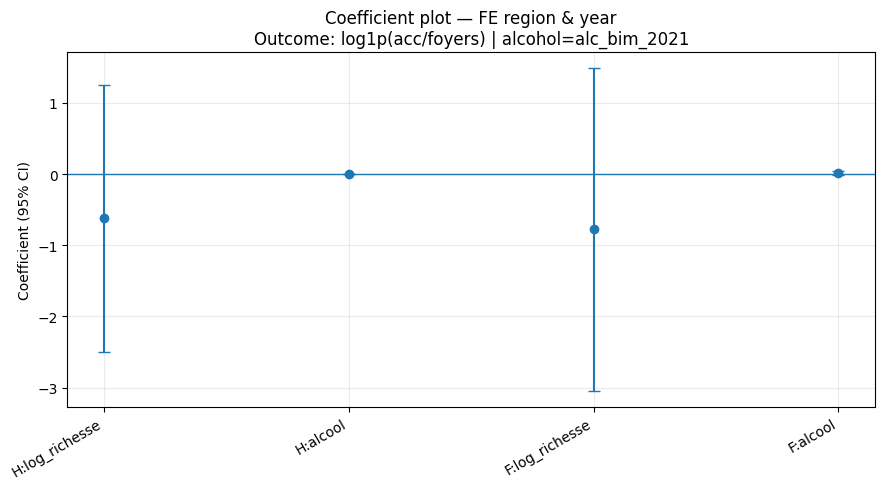

({'H': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x217a26255d0>,
  'F': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x21766a30490>},
      region_id                      region  year  S         y  richesse  \
 0            1                   OUTRE-MER  2020  H  6.451534  0.816090   
 1           11               ÎLE-DE-FRANCE  2020  H  6.142173  3.693009   
 2           24         CENTRE-VAL DE LOIRE  2020  H  2.629482  1.324900   
 3           27     BOURGOGNE-FRANCHE-COMTÉ  2020  H  2.116467  1.361757   
 4           28                   NORMANDIE  2020  H  2.521434  1.317013   
 5           32             HAUTS DE FRANCE  2020  H  1.868479  1.292271   
 6           44                   GRAND EST  2020  H  2.417196  1.517944   
 7           52            PAYS DE LA LOIRE  2020  H  1.871533  1.323323   
 8           53                    BRETAGNE  2020  H  2.548821  1.337357   
 9           75          NOUVELLE AQUITAINE  2020  H  2.974234 

In [177]:
graph_region.plot_coef_panel_FE(region_df, years=range(2020, 2025), alcohol_base="alc_bim", alcohol_year=2021)
